# Optimization of Brazilian Football Championship with Genetic Algorithm

## 1. The Championship

The Brazilian Football Championship is the main tournament of the most popular sport in Brazil. Most of the country is represented through one of the twenty teams (the Northern region was present in former editions). Brazil is a continent-sized country, so this tournament involves long trips, specially for teams in the Northeast region.<br> 

Starting with a set of conditions that will be discussed later, we will use Genetic Algorithms to propose a possible sequence of matches that minimize the impact of these long trips, although it is very clear there are teams who are geographically distant from the rest and there is no way to have every team with the same total distance. We try three different metrics for this optimization, all of them based on the distances traveled by each team.<br>

This kind of problem is known as **TTP, Traveling Tournament Problem**. There is a huge number of possible combinations and it is really hard to get the optimum solution, even for a small number of teams.

## 2. Available Data

It is very hard to create from scratch a table with the matches for each round. For this project, we will use the table of matches from the 2020 Championship. We will try to improve on that with our algorithm.

Let's import the required libraries to show these datasets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

%matplotlib inline

### 2.1. List of Teams

We need the list of the twenty teams with their home city. As we are interested in the distance traveled by each team, we will get the coordinates (latitude and longitude) for the center of the city as an approximation.

In [2]:
list_teams_20 = pd.read_csv('teams.csv')
list_teams_20.head()

,Team,City
0,Atlético Goianiense,Goiânia
1,Atlético Mineiro,Belo Horizonte
2,Athletico Paranaense,Curitiba
3,Bahia,Salvador
4,Botafogo,Rio de Janeiro


Later we will set up a 20x20 table with the distance between each team's cities.

### 2.2. 2020 Championship

Our starting point is the 2020 Championship, where we have the match order for each of the twenty teams. There are two halves, where the second one repeats the order of the first, but flipping the home and away teams. Taking this into account, we only need to worry about the first half.

We represent the matches for the first half with two tables, one with the opponents in each round and another telling us if the team plays at their home stadium or away (*h* or *a*).

#### 2.2.1 Sequence of matches

In [3]:
matches_20 = pd.read_csv('matches.csv')
matches_20.head()

,Team,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17,Round 18,Round 19
0,Athlético Paranaense,Fortaleza,Goiás,Santos,Palmeiras,Fluminense,Atlético Mineiro,Red Bull Bragantino,Vasco da Gama,Botafogo,Coritiba,São Paulo,Bahia,Flamengo,Ceará,Internacional,Corinthians,Atlético Goianiense,Grêmio,Sport
1,Atlético Goianiense,Corinthians,Flamengo,Sport,Internacional,Goiás,Ceará,Fluminense,Grêmio,Vasco da Gama,Bahia,Atlético Mineiro,Botafogo,Fortaleza,São Paulo,Red Bull Bragantino,Santos,Athlético Paranaense,Palmeiras,Coritiba
2,Atlético Mineiro,Flamengo,Corinthians,Ceará,Botafogo,Internacional,Athlético Paranaense,São Paulo,Coritiba,Santos,Red Bull Bragantino,Atlético Goianiense,Grêmio,Vasco da Gama,Fortaleza,Goiás,Fluminense,Bahia,Sport,Palmeiras
3,Bahia,Botafogo,Coritiba,Red Bull Bragantino,São Paulo,Ceará,Palmeiras,Flamengo,Internacional,Grêmio,Atlético Goianiense,Corinthians,Athlético Paranaense,Sport,Vasco da Gama,Fluminense,Goiás,Atlético Mineiro,Fortaleza,Santos
4,Botafogo,Bahia,Red Bull Bragantino,Fortaleza,Atlético Mineiro,Flamengo,Internacional,Coritiba,Corinthians,Athlético Paranaense,Vasco da Gama,Santos,Atlético Goianiense,Fluminense,Palmeiras,Sport,Grêmio,Goiás,São Paulo,Ceará


#### 2.2.2 Match location

In [4]:
location_20 = pd.read_csv('location.csv')
location_20.head()

,Team,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17,Round 18,Round 19
0,Athlético Paranaense,a,h,a,h,h,a,h,a,h,h,a,h,a,h,a,h,a,h,a
1,Atlético Goianiense,a,h,h,a,a,h,a,h,a,a,h,h,a,a,h,a,h,h,a
2,Atlético Mineiro,a,h,h,a,a,h,h,a,a,h,a,h,h,a,h,h,a,h,a
3,Bahia,a,h,h,a,a,h,h,a,h,h,a,a,h,h,a,a,h,h,a
4,Botafogo,h,a,a,h,a,h,h,a,a,h,h,a,h,h,a,a,h,a,h


## 3. Data Transformation

We need to alter the table so that we can update the list of teams. We will replace each team by their position in the alphabetical order. For example, *Athlético Paranaense* will be replaced by *Team01*, *Atlético Goianiense* by *Team02*, and so on. We will have three generic tables.

In [5]:
generic=['Team01','Team02','Team03','Team04','Team05','Team06','Team07','Team08','Team09','Team10',
         'Team11','Team12','Team13','Team14','Team15','Team16','Team17','Team18','Team19','Team20']

In [6]:
list1=list_teams_20['Team'].tolist()
list_teams = list_teams_20.replace(list1,generic)
list_teams.drop(columns=['City'],inplace=True)
list_teams = list_teams.set_index('Team')
list_teams.head()

""
Team
Team01
Team02
Team03
Team04
Team05


In [7]:
list1 = matches_20['Team'].tolist()
matches = matches_20.replace(list1,generic)
matches = matches.set_index('Team')
matches.head()

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17,Round 18,Round 19
Team,,,,,,,,,,,,,,,,,,,
Team01,Team11,Team12,Team17,Team15,Team10,Team03,Team16,Team20,Team05,Team08,Team18,Team04,Team09,Team06,Team14,Team07,Team02,Team13,Team19
Team02,Team07,Team09,Team19,Team14,Team12,Team06,Team10,Team13,Team20,Team04,Team03,Team05,Team11,Team18,Team16,Team17,Team01,Team15,Team08
Team03,Team09,Team07,Team06,Team05,Team14,Team01,Team18,Team08,Team17,Team16,Team02,Team13,Team20,Team11,Team12,Team10,Team04,Team19,Team15
Team04,Team05,Team08,Team16,Team18,Team06,Team15,Team09,Team14,Team13,Team02,Team07,Team01,Team19,Team20,Team10,Team12,Team03,Team11,Team17
Team05,Team04,Team16,Team11,Team03,Team09,Team14,Team08,Team07,Team01,Team20,Team17,Team02,Team10,Team15,Team19,Team13,Team12,Team18,Team06


In [8]:
list1 = location_20['Team'].tolist()
locations = location_20.replace(list1,generic)
locations = locations.replace(['h','a'],[0,1])
locations = locations.set_index('Team')
locations.head()

,Round 1,Round 2,Round 3,Round 4,Round 5,Round 6,Round 7,Round 8,Round 9,Round 10,Round 11,Round 12,Round 13,Round 14,Round 15,Round 16,Round 17,Round 18,Round 19
Team,,,,,,,,,,,,,,,,,,,
Team01,1,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,1
Team02,1,0,0,1,1,0,1,0,1,1,0,0,1,1,0,1,0,0,1
Team03,1,0,0,1,1,0,0,1,1,0,1,0,0,1,0,0,1,0,1
Team04,1,0,0,1,1,0,0,1,0,0,1,1,0,0,1,1,0,0,1
Team05,0,1,1,0,1,0,0,1,1,0,0,1,0,0,1,1,0,1,0


## 4. Genetic Algorithm and Definition of the Problem

This kind of problem is very complex, as there are too many possible combinations. For the Brazilian Championship, it is probable that the full table of matches is made by hand, with only one assumption:
1. No team can play more than two rounds in a row at home or away.

For our exercise, we will work with an Express Tournament. The number of rounds is the same, but we add another condition:

2. The teams don't return to their home city, going from one match to the location of the next.


This new condition is only relevant to our evaluation metric. Without this condition, the total distance traveled by each team would be the sum of distance from their home cities to all the others. By adding this artificial condition, we are able to run our algorithm. The other option would be to develop a more complex metric.

We have three tables to work with. To get the optimum results, we should make changes in all of them at the same time, but this is rather difficult. Let's tackle one at a time, leaving the other two fixed.

For each case, we will create a initial set of possible configurations, represented by a vector or a matrix. They will be our genes for the genetic algorithm. These are evaluated based on the metrics we propose and the best ones will be used to generate a new set of configurations. This process is repeated a pre-determined number of times and should result on an optimized result.

### 4.1. List of teams

We are going to make changes in the order of the teams, keeping the matches and location tables fixed. That means defining which team is '*Team01*', which one is '*Team02*', until '*Team20*'. The original list is in alphabetical order.

In [9]:
print('There are',math.factorial(20),'possibilities for this set of teams.')

There are 2432902008176640000 possibilities for this set of teams.


It is very obvious there would be a high computational cost if we must go through all of them.

In this case, our gene is a vector with the numbers from 1 to 20. The numbers represent each team in the alphabetical order, and the position in the vector represents the position in the generic list. That is, if the first number in the vector is 5, the fifth team in the alphabetical list will be '*Team01*'. The mutation for each generation is the selection of two positions in the vector and swapping the teams.

### 4.2. Match location

We are going to make changes to the location table, keeping the order and matches tables fixed. That is, define the sequence of home and away matches for each team. It is important to respect the condition that no team can play more than two games in a row at home or away.

In this case, our gene is a 20x19 matrix, where each row is a team and each column is a round. The mutation is to pick a single match in the matches table and swap the home team. It is a valid mutation if the condition above is met.

### 4.3. Match order

We are going to make changes to the matches table, keeping the order of the teams fixed. That is, define the sequence of matches for each team.  When we alter the sequence of the rounds, this also affects the location table. It is important to respect the condition that no team can play more than two games in a row at home or away.

To simplify this case, our gene is a vector with numbers from 1 to 19, The numbers represent each round in the original order, and the position in the vector represents the position in the new order. That is, if the first number in the vector is 5, the fifth round in the original order will be considered the first round. The mutation for each generation is the selection of two positions in the vector and swapping the rounds. Again, it is important to respect the condition that no team can play more than two games in a row at home or away.

## 5. Tables of Distances

We need four tables in our dataset:
1. list of teams
2. table with matches
3. table with locations
4. distance between cities

The last table is used only in our evaluation function. It is the only one missing, so let's create it.

We will load a library that returns the city's coordinates (Latitude and Longitude) and then we will create a new table with the distance between the all the cities.

Loading the required libraries.

In [10]:
!pip3 install geopy
from geopy.geocoders import Nominatim
import time
app = Nominatim(user_agent="gabrasileirao")

Defining the function that returns the coordinates.

In [11]:
def get_location_by_address(address):
    """This function returns a location as raw from an address
    will repeat until success"""
    time.sleep(1)
    try:
        return app.geocode(address).raw
    except:
        return get_location_by_address(address)

For each team, let's get the coordinates.

In [12]:
list_teams_20['Latitude']=0.
list_teams_20['Longitude']=0.
for ii in range(list_teams_20.shape[0]):
    print(ii)
    address = [list_teams_20.iloc[ii,1],'Brazil']
    location = get_location_by_address(address)
    list_teams_20.iloc[ii,-2] = location["lat"]
    list_teams_20.iloc[ii,-1] = location["lon"]
list_teams_20.head()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


,Team,City,Latitude,Longitude
0,Atlético Goianiense,Goiânia,-16.680882,-49.2532691
1,Atlético Mineiro,Belo Horizonte,-19.9227318,-43.9450948
2,Athletico Paranaense,Curitiba,-25.4295963,-49.2712724
3,Bahia,Salvador,-12.9822499,-38.4812772
4,Botafogo,Rio de Janeiro,-22.9110137,-43.2093727


In [13]:
list_teams_20['Latitude']=list_teams_20['Latitude'].astype(float)
list_teams_20['Longitude']=list_teams_20['Longitude'].astype(float)

Let's put each city in the map.

In [14]:
!pip install folium
import folium # map rendering library

In [15]:
#map centered at Brasília
map_brasil = folium.Map(location=[-10.3333333, -53.2], zoom_start=4)

# add markers to map
for lat, lng, time in zip(list_teams_20['Latitude'], list_teams_20['Longitude'], list_teams_20['Team']):
    label = '{}'.format(time)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brasil)  
    
map_brasil

We have 20 teams spreading over 11 cities, in 9 states. Now, we can create the table with the distances between each team. Again, we are defining a function to do the math.

Let's create an empty matrix.

In [16]:
distances = pd.DataFrame(columns=['Team']+list_teams_20['Team'].tolist())
distances['Team'] = list_teams_20['Team'].tolist()
distances.head()

,Team,Atlético Goianiense,Atlético Mineiro,Athletico Paranaense,Bahia,Botafogo,Ceará,Corinthians,Coritiba,Flamengo,...,Fortaleza,Goiás,Grêmio,Internacional,Palmeiras,Red Bull Bragantino,Santos,São Paulo,Sport,Vasco da Gama
0,Atlético Goianiense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Atlético Mineiro,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Athletico Paranaense,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Bahia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Botafogo,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Loading the library that calculates the distance from the coordinates.

In [17]:
!pip install haversine
import haversine as hs


In [18]:
for ii in range(len(list_teams_20)):
    for jj in range(len(list_teams_20)):
        loc1=(list_teams_20.iloc[ii,-2],list_teams_20.iloc[ii,-1])
        loc2=(list_teams_20.iloc[jj,-2],list_teams_20.iloc[jj,-1])
        distances.iloc[ii,jj+1]=hs.haversine(loc1,loc2)

distances.head()

,Team,Atlético Goianiense,Atlético Mineiro,Athletico Paranaense,Bahia,Botafogo,Ceará,Corinthians,Coritiba,Flamengo,...,Fortaleza,Goiás,Grêmio,Internacional,Palmeiras,Red Bull Bragantino,Santos,São Paulo,Sport,Vasco da Gama
0,Atlético Goianiense,0,666.215,972.816,1228.42,937.644,1856.43,811.308,972.816,937.644,...,1856.43,0,1498.19,1498.19,811.308,752.725,864.739,811.308,1830,937.644
1,Atlético Mineiro,666.215,0,820.485,966.725,340.896,1894.08,489.691,820.485,340.896,...,1894.08,666.215,1341.83,1341.83,489.691,430.9,512.134,489.691,1640.7,340.896
2,Athletico Paranaense,972.816,820.485,0,1786.64,675.611,2672.15,338.956,0,675.611,...,2672.15,972.816,546.903,546.903,338.956,390.537,338.708,338.956,2460.42,675.611
3,Bahia,1228.42,966.725,1786.64,0,1211.69,1028.76,1455.69,1786.64,1211.69,...,1028.76,1228.42,2305.24,2305.24,1455.69,1397.62,1474.19,1455.69,673.975,1211.69
4,Botafogo,937.644,340.896,675.611,1211.69,0,2191.62,357.01,675.611,0,...,2191.62,937.644,1123.76,1123.76,357.01,341.295,339.459,357.01,1875.55,0


In [19]:
distances=distances.set_index('Team')
distances.head()

,Atlético Goianiense,Atlético Mineiro,Athletico Paranaense,Bahia,Botafogo,Ceará,Corinthians,Coritiba,Flamengo,Fluminense,Fortaleza,Goiás,Grêmio,Internacional,Palmeiras,Red Bull Bragantino,Santos,São Paulo,Sport,Vasco da Gama
Team,,,,,,,,,,,,,,,,,,,,
Atlético Goianiense,0,666.215,972.816,1228.42,937.644,1856.43,811.308,972.816,937.644,937.644,1856.43,0,1498.19,1498.19,811.308,752.725,864.739,811.308,1830,937.644
Atlético Mineiro,666.215,0,820.485,966.725,340.896,1894.08,489.691,820.485,340.896,340.896,1894.08,666.215,1341.83,1341.83,489.691,430.9,512.134,489.691,1640.7,340.896
Athletico Paranaense,972.816,820.485,0,1786.64,675.611,2672.15,338.956,0,675.611,675.611,2672.15,972.816,546.903,546.903,338.956,390.537,338.708,338.956,2460.42,675.611
Bahia,1228.42,966.725,1786.64,0,1211.69,1028.76,1455.69,1786.64,1211.69,1211.69,1028.76,1228.42,2305.24,2305.24,1455.69,1397.62,1474.19,1455.69,673.975,1211.69
Botafogo,937.644,340.896,675.611,1211.69,0,2191.62,357.01,675.611,0,0,2191.62,937.644,1123.76,1123.76,357.01,341.295,339.459,357.01,1875.55,0


In [20]:
print('For example, the distance between Bahia and Grêmio is:',distances.loc['Bahia','Grêmio'],'kilometers.')

For example, the distance between Bahia and Grêmio is: 2305.244411273193 kilometers.


## 6. Evaluation Function

We need to develop a function that gives us a score of a configuration so we can determine the best ones to create the next generation to be tested. This is the function we want to optimize. We will base it on the distance traveled by each team. For example, for '*Team01*', the distance between its home city to the location of the first match, plus the distance to the location of the second one, and so on.<br>
We have two conditions in our tournament:
1. No team can play more than two rounds in a row at home or away.
2. The teams don't return to their home city, going from one match to the location of the next.

We will try three different metrics, but they all depend on the vector with the total distance traveled by each team.

Our three proposed evaluation functions:
1. minimizing the total sum of the distance;
2. minimizing the difference between the smallest and the largest distances;
3. minimizing the standard deviation of the distribution of distances.

To understand the process, let's evaluate the actual table from the 2020 Championship. Then we can see if we get a better result with our algorithm.

With the lists of locations and the matches, we can get the sequence of travels for each team, starting and ending at home. Each row shows the location of the match for a team. Every on starts at home and then moves to the first match, when half of the teams doesn't travel.

In [21]:
rounds=['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6', 'Round 7', 'Round 8', 'Round 9', 
        'Round 10', 'Round 11', 'Round 12', 'Round 13', 'Round 14', 'Round 15', 'Round 16', 'Round 17', 
        'Round 18', 'Round 19']

trek=[]
for jj in range(len(generic)):
    team_trek=[generic[jj]]+2*matches.loc[generic[jj],:].tolist()+[generic[jj]]
    for ii in range(len(rounds)):
        if locations.loc[generic[jj],rounds[ii]]==0:
            team_trek[ii+1]=generic[jj]
        else:
            team_trek[ii+20]=generic[jj]

    trek.append(team_trek)
    
trek=pd.DataFrame(trek)
trek

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,Team01,Team11,Team01,Team17,Team01,Team01,Team03,Team01,Team20,Team01,...,Team01,Team04,Team01,Team06,Team01,Team07,Team01,Team13,Team01,Team01
1,Team02,Team07,Team02,Team02,Team14,Team12,Team02,Team10,Team02,Team20,...,Team03,Team05,Team02,Team02,Team16,Team02,Team01,Team15,Team02,Team02
2,Team03,Team09,Team03,Team03,Team05,Team14,Team03,Team03,Team08,Team17,...,Team03,Team13,Team20,Team03,Team12,Team10,Team03,Team19,Team03,Team03
3,Team04,Team05,Team04,Team04,Team18,Team06,Team04,Team04,Team14,Team04,...,Team04,Team04,Team19,Team20,Team04,Team04,Team03,Team11,Team04,Team04
4,Team05,Team05,Team16,Team11,Team05,Team09,Team05,Team05,Team07,Team01,...,Team17,Team05,Team10,Team15,Team05,Team05,Team12,Team05,Team06,Team05
5,Team06,Team19,Team06,Team03,Team06,Team06,Team02,Team06,Team06,Team14,...,Team06,Team12,Team06,Team06,Team07,Team18,Team06,Team08,Team06,Team06
6,Team07,Team07,Team03,Team13,Team07,Team07,Team18,Team12,Team07,Team07,...,Team04,Team07,Team07,Team17,Team07,Team07,Team09,Team07,Team14,Team07
7,Team08,Team08,Team04,Team08,Team08,Team16,Team08,Team05,Team08,Team12,...,Team20,Team08,Team18,Team08,Team11,Team08,Team17,Team08,Team02,Team08
8,Team09,Team09,Team02,Team08,Team09,Team09,Team17,Team04,Team09,Team09,...,Team12,Team09,Team01,Team19,Team09,Team16,Team09,Team09,Team18,Team09
9,Team10,Team13,Team10,Team10,Team16,Team01,Team10,Team10,Team18,Team09,...,Team10,Team08,Team10,Team10,Team04,Team10,Team06,Team17,Team10,Team10


Let's load the original list of teams.

In [22]:
list_teams['Team']=list_teams_20['Team'].tolist()
list_teams

,Team
Team,
Team01,Atlético Goianiense
Team02,Atlético Mineiro
Team03,Athletico Paranaense
Team04,Bahia
Team05,Botafogo
Team06,Ceará
Team07,Corinthians
Team08,Coritiba
Team09,Flamengo


In [23]:
trek_list=[]
for ii in range(trek.shape[0]):
    team_travel=0
    for jj in range(trek.shape[1]-1):
        team_travel += distances.loc[list_teams.loc[trek.iloc[ii,jj],'Team'],
                                  list_teams.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_travel)

trek_list

[37736.14248174618,
 30100.61831962806,
 33749.727289039845,
 42171.58119573057,
 28089.63354469981,
 69076.81883489023,
 25969.252511542232,
 33176.14474039522,
 28190.258200222743,
 28789.744436597444,
 67891.38731485106,
 34395.8232362118,
 41080.00648388408,
 39607.78123132498,
 27241.23720619874,
 25683.52486915348,
 28362.891226696363,
 27928.186482089965,
 46899.301527060175,
 29258.46337371812]

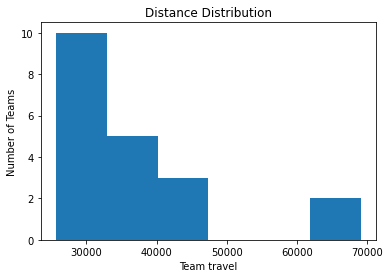

In [24]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Team travel')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

The first evaluation function is the sum of the distances.

In [25]:
total_distance = np.sum(trek_list)
print('The total distance for this configuration is:',total_distance)

The total distance for this configuration is: 725398.524505681


The second evaluation function is the difference between the largest and smallest distance.

In [26]:
difference = max(trek_list) - min(trek_list)
print('The difference in the largest and the smallest distances traveled for this configuration is:',difference)

The difference in the largest and the smallest distances traveled for this configuration is: 43393.29396573675


We have the distance distribution, so we can get the standard deviation, our third evaluation function.

In [27]:
standard_deviation = np.std(trek_list)
print('The standard deviation for this configuration is:',standard_deviation)

The standard deviation for this configuration is: 12220.999097401962


We mapped the process, step by step. We will use this to evaluate each configuration we create, so it is better to define a function for it.

In [28]:
def evaluation(team_order,match_order,round_order):
    trek = []
    rounds = round_order.columns
    for jj in range(len(generic)):
        team_trek = [generic[jj]] + 2*round_order.loc[generic[jj],:].tolist() + [generic[jj]]
        for ii in range(len(rounds)):
            if match_order.loc[generic[jj],rounds[ii]] == 0:
                team_trek[ii+1] = generic[jj]
            else:
                team_trek[ii+team_order.shape[0]] = generic[jj]

        trek.append(team_trek)

    trek = pd.DataFrame(trek)
    trek_list = []
    for ii in range(trek.shape[0]):
        team_travel = 0
        for jj in range(trek.shape[1]-1):
            team_travel += distances.loc[team_order.loc[trek.iloc[ii,jj],'Team'],
                                      team_order.loc[trek.iloc[ii,jj+1],'Team']]

        trek_list.append(team_travel)
    total_distance = np.sum(trek_list)
    difference = max(trek_list) - min(trek_list)
    standard_deviation = np.std(trek_list)
    optimization = [total_distance,difference,standard_deviation]
    return optimization



## 7. Optimizing the Team Order

We are going to modify the order of the teams while keeping the locations and the matches tables fixed. In other words, we will define what team is '*Team01*, which one is '*Team02*', up to '*Team20*'.

In [29]:
matches_solution = matches.copy()
location_solution = locations.copy()

Our gene is a vector with the ordering of the teams, based on the original order.

In [30]:
print('That is, the vector (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) is:', list_teams_20['Team'].tolist())

That is, the vector (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) is: ['Atlético Goianiense', 'Atlético Mineiro', 'Athletico Paranaense', 'Bahia', 'Botafogo', 'Ceará', 'Corinthians', 'Coritiba', 'Flamengo', 'Fluminense', 'Fortaleza', 'Goiás', 'Grêmio', 'Internacional', 'Palmeiras', 'Red Bull Bragantino', 'Santos', 'São Paulo', 'Sport', 'Vasco da Gama']


At the end of our algorithm, we will present a graph with the evolution of the best evaluation function for each generation. We hope to find an optimized value.<br>
We have four parameters to define:
1. the number of genes (configurations) we will evaluate in each generation: **6**;
2. the number of genes we will use to create the new generation: **2**;
3. the number of generations: **500**;
4. the original configurations.

We will create six random configurations below.

In [31]:
import random
gene_pool=[]
for ii in range(6):
    gene = random.sample(range(0, 20),k=20)
    gene_pool.append(gene)
        
gene_pool=pd.DataFrame(gene_pool)
gene_pool

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,15,1,13,19,3,17,0,12,7,6,9,11,10,4,16,14,2,18,5,8
1,17,16,11,8,18,12,1,10,4,6,7,3,19,13,15,2,14,0,9,5
2,6,8,0,13,18,5,10,4,7,19,12,17,14,11,9,15,2,16,3,1
3,8,10,9,1,16,18,12,5,11,0,7,14,6,3,4,15,2,19,13,17
4,7,9,8,11,3,17,18,13,0,4,15,6,2,14,5,12,10,1,19,16
5,5,15,8,12,4,11,18,16,0,9,19,17,6,14,10,13,3,7,1,2


Here is the core of our algorithm. For each generation, six genes will be evaluated. The best two configurations will be kept and two new candidates will be created from each, by swapping the position of two teams.<br>
At the end, we will have the order that minimizes our chosen evaluation function and a graph with the evolution of the metric for each generation.

### 7.1 First evaluation - Total Sum

Starting with our first function, sum of the distances.

In [32]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 0 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(gene_pool.shape[0]):
        #creating team order
        list_teams_gene = []
        for jj in range(gene_pool.shape[1]):
            list_teams_gene.append(list_teams_20['Team'].tolist()[gene_pool.iloc[ii,jj].astype(int)])
        
        team_order = list_teams.copy()
        team_order['Team']=list_teams_gene
        #evaluation function
        scores.append(evaluation(team_order, location_solution, matches_solution)[method])
    
    #ranking results
    gene_pool['evaluation']=scores
    gene_pool = gene_pool.sort_values(by=['evaluation']).reset_index(drop=True)
    
    #storing best result
    metric.append(gene_pool.iloc[0,-1])
    
    #creating new candidates
    gene_pool.iloc[2,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[3,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[4,:] = gene_pool.iloc[1,:]
    gene_pool.iloc[5,:] = gene_pool.iloc[1,:]
    
    for ii in range(2,6):
        x1 = random.randint(0,19)
        x2 = x1
        while x2 == x1:
            x2 = random.randint(0,19)
        pos1 = gene_pool.iloc[ii,x1]
        pos2 = gene_pool.iloc[ii,x2]
        gene_pool.iloc[ii,x1] = pos2
        gene_pool.iloc[ii,x2] = pos1
    
    #prepping for next generation
    gene_pool.drop(columns=['evaluation'],inplace=True)
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


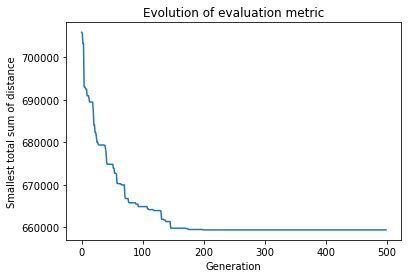

In [33]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest total sum of distance')
plt.title('Evolution of evaluation metric')
plt.show()

In [34]:
print('The best configuration has a total distance of:',metric[-1],', ordered as below.')
print('The original order had a total of',total_distance,'km. That means we reduced the total in',round(100*(1-metric[-1]/total_distance)),'%')

The best configuration has a total distance of: 659363.8482429333 , ordered as below.
The original order had a total of 725398.524505681 km. That means we reduced the total in 9 %


In [35]:
best_list_teams = []
for jj in range(gene_pool.shape[1]):
    best_list_teams.append(list_teams_20['Team'].tolist()[gene_pool.iloc[0,jj].astype(int)])
best_list_teams     

['Botafogo',
 'São Paulo',
 'Santos',
 'Grêmio',
 'Athletico Paranaense',
 'Red Bull Bragantino',
 'Sport',
 'Corinthians',
 'Goiás',
 'Vasco da Gama',
 'Flamengo',
 'Fortaleza',
 'Palmeiras',
 'Bahia',
 'Fluminense',
 'Coritiba',
 'Internacional',
 'Atlético Mineiro',
 'Ceará',
 'Atlético Goianiense']

In [36]:
best_order_teams = list_teams.copy()
best_order_teams['Team'] = best_list_teams
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[best_order_teams.loc[trek.iloc[ii,jj],'Team'],
                                  best_order_teams.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
best_order_teams['Total Distance']=trek_list
best_order_teams

,Team,Total Distance
Team,,
Team01,Botafogo,29380.750887
Team02,São Paulo,23179.576684
Team03,Santos,27864.516127
Team04,Grêmio,36769.010348
Team05,Athletico Paranaense,31855.342649
Team06,Red Bull Bragantino,26768.478096
Team07,Sport,55896.261040
Team08,Corinthians,23947.545786
Team09,Goiás,29436.584653


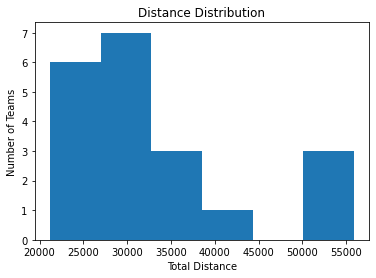

In [37]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

### 7.2 Second evaluation - Difference

Moving on to the second function, the difference between the smaller and the largest distance.

In [38]:
gene_pool=[]
for ii in range(6):
    gene = random.sample(range(0, 20),k=20)
    gene_pool.append(gene)
        
gene_pool=pd.DataFrame(gene_pool)
gene_pool

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,12,0,7,3,13,10,15,16,11,14,5,8,6,1,2,18,19,17,4,9
1,0,14,15,17,6,4,1,12,3,16,11,8,18,13,9,7,10,19,5,2
2,17,6,10,18,9,0,13,19,5,1,16,15,7,12,2,4,3,14,11,8
3,8,1,3,19,16,0,2,17,7,10,5,18,6,15,9,4,12,14,11,13
4,10,3,8,13,9,12,11,2,0,15,5,19,16,18,7,6,4,1,14,17
5,18,5,3,0,11,7,10,8,1,12,6,2,9,13,15,17,14,4,16,19


In [39]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 1 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(gene_pool.shape[0]):
        #creating team order
        list_teams_gene = []
        for jj in range(gene_pool.shape[1]):
            list_teams_gene.append(list_teams_20['Team'].tolist()[gene_pool.iloc[ii,jj].astype(int)])
        
        team_order = list_teams.copy()
        team_order['Team']=list_teams_gene
        #evaluation function
        scores.append(evaluation(team_order, location_solution, matches_solution)[method])
    
    #ranking results
    gene_pool['evaluation']=scores
    gene_pool = gene_pool.sort_values(by=['evaluation']).reset_index(drop=True)
    
    #storing best result
    metric.append(gene_pool.iloc[0,-1])
    
    #creating new candidates
    gene_pool.iloc[2,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[3,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[4,:] = gene_pool.iloc[1,:]
    gene_pool.iloc[5,:] = gene_pool.iloc[1,:]
    
    for ii in range(2,6):
        x1 = random.randint(0,19)
        x2 = x1
        while x2 == x1:
            x2 = random.randint(0,19)
        pos1 = gene_pool.iloc[ii,x1]
        pos2 = gene_pool.iloc[ii,x2]
        gene_pool.iloc[ii,x1] = pos2
        gene_pool.iloc[ii,x2] = pos1
    
    #prepping for next generation
    gene_pool.drop(columns=['evaluation'],inplace=True)
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


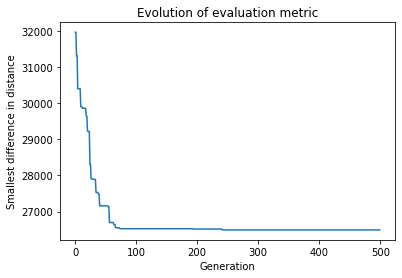

In [40]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest difference in distance')
plt.title('Evolution of evaluation metric')
plt.show()

In [41]:
print('The best configuration has a difference of distance of:',metric[-1],', ordered as below.')
print('The original order had a difference of',difference,'km. That means we reduced the total in',round(100*(1-metric[-1]/difference)),'%')

The best configuration has a difference of distance of: 26492.703026263618 , ordered as below.
The original order had a difference of 43393.29396573675 km. That means we reduced the total in 39 %


In [42]:
best_list_teams = []
for jj in range(gene_pool.shape[1]):
    best_list_teams.append(list_teams_20['Team'].tolist()[gene_pool.iloc[0,jj].astype(int)])
best_list_teams    

['Corinthians',
 'Athletico Paranaense',
 'Fortaleza',
 'Goiás',
 'Coritiba',
 'São Paulo',
 'Internacional',
 'Vasco da Gama',
 'Santos',
 'Flamengo',
 'Palmeiras',
 'Atlético Mineiro',
 'Fluminense',
 'Grêmio',
 'Bahia',
 'Sport',
 'Botafogo',
 'Red Bull Bragantino',
 'Ceará',
 'Atlético Goianiense']

In [43]:
best_order_teams = list_teams.copy()
best_order_teams['Team'] = best_list_teams
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[best_order_teams.loc[trek.iloc[ii,jj],'Team'],
                                  best_order_teams.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
best_order_teams['Total Distance']=trek_list
best_order_teams

,Team,Total Distance
Team,,
Team01,Corinthians,28120.655441
Team02,Athletico Paranaense,31886.058943
Team03,Fortaleza,53320.624986
Team04,Goiás,33102.709863
Team05,Coritiba,31880.614706
Team06,São Paulo,27114.299730
Team07,Internacional,37333.614771
Team08,Vasco da Gama,27618.675347
Team09,Santos,27224.687815


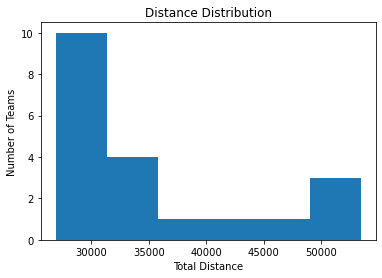

In [44]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

### 7.3 Third evaluation - Standard Deviation

Moving on to the third function, the standard deviation of the distance distribution. 

In [45]:
gene_pool=[]
for ii in range(6):
    gene = random.sample(range(0, 20),k=20)
    gene_pool.append(gene)
        
gene_pool=pd.DataFrame(gene_pool)
gene_pool

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,16,3,11,12,9,18,1,7,14,2,6,5,13,4,19,8,17,15,10,0
1,6,2,19,10,8,17,5,11,18,13,16,1,0,15,12,3,9,14,4,7
2,6,15,12,8,18,0,17,11,9,19,14,1,5,2,7,16,13,10,3,4
3,3,6,16,13,9,15,10,0,1,4,5,18,8,19,7,11,17,12,14,2
4,16,11,18,6,5,10,12,14,7,9,17,13,15,1,8,3,4,2,19,0
5,19,3,9,1,12,0,15,10,4,16,5,17,11,18,13,7,2,6,14,8


In [46]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 2 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(gene_pool.shape[0]):
        #creating team order
        list_teams_gene = []
        for jj in range(gene_pool.shape[1]):
            list_teams_gene.append(list_teams_20['Team'].tolist()[gene_pool.iloc[ii,jj].astype(int)])
        
        team_order = list_teams.copy()
        team_order['Team']=list_teams_gene
        #evaluation function
        scores.append(evaluation(team_order, location_solution, matches_solution)[method])
    
    #ranking results
    gene_pool['evaluation']=scores
    gene_pool = gene_pool.sort_values(by=['evaluation']).reset_index(drop=True)
    
    #storing best result
    metric.append(gene_pool.iloc[0,-1])
    
    #creating new candidates
    gene_pool.iloc[2,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[3,:] = gene_pool.iloc[0,:]
    gene_pool.iloc[4,:] = gene_pool.iloc[1,:]
    gene_pool.iloc[5,:] = gene_pool.iloc[1,:]
    
    for ii in range(2,6):
        x1 = random.randint(0,19)
        x2 = x1
        while x2 == x1:
            x2 = random.randint(0,19)
        pos1 = gene_pool.iloc[ii,x1]
        pos2 = gene_pool.iloc[ii,x2]
        gene_pool.iloc[ii,x1] = pos2
        gene_pool.iloc[ii,x2] = pos1
    
    #prepping for next generation
    gene_pool.drop(columns=['evaluation'],inplace=True)
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


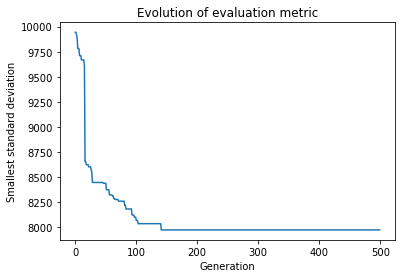

In [47]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest standard deviation')
plt.title('Evolution of evaluation metric')
plt.show()

In [48]:
print('The best configuration has a standard deviation of:',metric[-1],', ordered as below.')
print('The original order had a difference of',standard_deviation,'. That means we reduced the total in',round(100*(1-metric[-1]/standard_deviation)),'%')

The best configuration has a standard deviation of: 7972.135087910702 , ordered as below.
The original order had a difference of 12220.999097401962 . That means we reduced the total in 35 %


In [49]:
best_list_teams = []
for jj in range(gene_pool.shape[1]):
    best_list_teams.append(list_teams_20['Team'].tolist()[gene_pool.iloc[0,jj].astype(int)])
best_list_teams    

['São Paulo',
 'Grêmio',
 'Atlético Goianiense',
 'Sport',
 'Red Bull Bragantino',
 'Vasco da Gama',
 'Corinthians',
 'Palmeiras',
 'Santos',
 'Botafogo',
 'Athletico Paranaense',
 'Fortaleza',
 'Internacional',
 'Atlético Mineiro',
 'Coritiba',
 'Goiás',
 'Fluminense',
 'Flamengo',
 'Ceará',
 'Bahia']

In [50]:
best_order_teams = list_teams.copy()
best_order_teams['Team'] = best_list_teams
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[best_order_teams.loc[trek.iloc[ii,jj],'Team'],
                                  best_order_teams.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
best_order_teams['Total Distance']=trek_list
best_order_teams

,Team,Total Distance
Team,,
Team01,São Paulo,28721.663596
Team02,Grêmio,39257.331631
Team03,Atlético Goianiense,34175.249224
Team04,Sport,47147.630080
Team05,Red Bull Bragantino,27713.749605
Team06,Vasco da Gama,26967.477637
Team07,Corinthians,26700.412331
Team08,Palmeiras,28742.018834
Team09,Santos,28441.081735


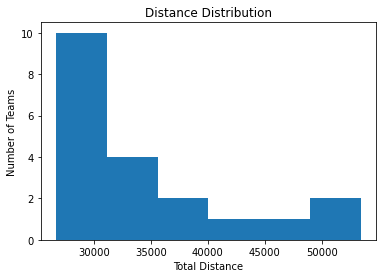

In [51]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

We have finished the optimization using only the order of the teams. Looking at the distances and their distributions, it seems that the third option, the standatd deviation, is the most equalitarian one.

## 8. Optimizing the Locations table

We are going to modify the location of the matches while keeping the order of the teams and the matches table fixed. In other words, we will define the sequence of home and away games for each team, respecting the condition that no team can play more than two games in a row at home or away.

In [52]:
matches_solution = matches.copy()
list_teams_solution = list_teams.copy()

For this case, our gene is a table just like the location table, where each row is a team and each column is a round. The mutation is done by randomly selecting a game in the matches table and swapping the home and away teams. We need to validate this mutation so the condition is still met.

Let's build a function that verifies the condition for all teams.

In [53]:
#returns 0 if there are no problems, 1 if condition is not valid
def verifyCondition(location_gene):
    ok = 0
    for ii in range(location_gene.shape[0]):
        for jj in range(location_gene.shape[1]-2):
            test = location_gene.iloc[ii,jj]+location_gene.iloc[ii,jj+1]+location_gene.iloc[ii,jj+2]
            if test == 0 or test == 3:
                ok = 1
        test = (1 - location_gene.iloc[ii,0]) + location_gene.iloc[ii,-2] + location_gene.iloc[ii,-1]
        if test == 0 or test == 3:
            ok = 1
        test = (1 - location_gene.iloc[ii,0]) + (1 - location_gene.iloc[ii,1]) + location_gene.iloc[ii,-1]
        if test == 0 or test == 3:
            ok = 1
    
    return ok    

At the end of our algorithm, we will present a graph with the evolution of the best evaluation function for each generation. We hope to find an optimized value.
We have four parameters to define:

1. the number of genes (configurations) we will evaluate in each generation: 6;
2. the number of genes we will use to create the new generation: 2;
3. the number of generations: 500;
4. the original configurations.

The creation of an original set of valid configurations is more complex in this case. From the original table, we are going to generate 5 new tables, with only one mutation each.

In [54]:
gene_pool = []
gene_pool.append(locations)
jj = 0
for ii in range(5):
    ok = 1
    #we will create new configurations until we find a valid one 
    while ok > 0:
        location_gene = locations.copy()
        #randomly selecting a team and a round
        x1 = random.randint(0,19)
        x2 = random.randint(0,18)
        team1 = generic[x1]
        team2 = matches_solution.iloc[x1,x2]
        location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
        location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]
        
        ok = verifyCondition(location_gene)
         
    gene_pool.append(location_gene)


### 8.1 First evaluation - Total sum

In [55]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 0 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(len(gene_pool)):
        scores.append(evaluation(list_teams_solution, gene_pool[ii], matches_solution)[method])
    
    #ranking results
    ranking = sorted(range(len(scores)), key=lambda k: scores[k])
    
    ranked_gene_pool = []
    for ii in range(len(gene_pool)):
        ranked_gene_pool.append(gene_pool[ranking[ii]])
    
    gene_pool = ranked_gene_pool
    
    #storing best result
    metric.append(np.min(scores))
    
    #creating new candidates    
    for ii in range(2,4):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[0].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene

    for ii in range(4,6):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[1].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene
        
    #prepping for next generation
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


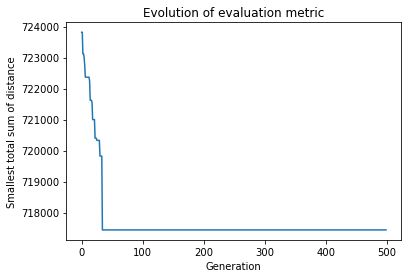

In [56]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest total sum of distance')
plt.title('Evolution of evaluation metric')
plt.show()

In [57]:
print('The best configuration has a total distance of:',metric[-1],', ordered as below.')
print('The original order had a total of',total_distance,'km. That means we reduced the total in',round(100*(1-metric[-1]/total_distance)),'%')

The best configuration has a total distance of: 717442.1922690459 , ordered as below.
The original order had a total of 725398.524505681 km. That means we reduced the total in 1 %


In [58]:
best_locations = gene_pool[0]
trek=[]
for jj in range(len(generic)):
    team_trek=[generic[jj]]+2*matches_solution.loc[generic[jj],:].tolist()+[generic[jj]]
    for ii in range(len(rounds)):
        if best_locations.loc[generic[jj],rounds[ii]]==0:
            team_trek[ii+1]=generic[jj]
        else:
            team_trek[ii+20]=generic[jj]

    trek.append(team_trek)
    
trek=pd.DataFrame(trek)

In [59]:
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[list_teams_solution.loc[trek.iloc[ii,jj],'Team'],
                                  list_teams_solution.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
list_teams_solution['Total Distance']=trek_list
list_teams_solution

,Team,Total Distance
Team,,
Team01,Atlético Goianiense,37736.142482
Team02,Atlético Mineiro,29539.060127
Team03,Athletico Paranaense,31912.217869
Team04,Bahia,42088.782686
Team05,Botafogo,28089.633545
Team06,Ceará,69076.818835
Team07,Corinthians,25969.252512
Team08,Coritiba,33176.144740
Team09,Flamengo,24640.195066


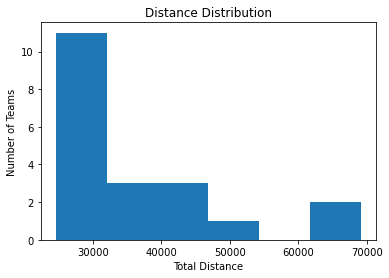

In [60]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

### 8.2 Second evaluation - Difference

In [61]:
gene_pool = []
gene_pool.append(locations)
jj = 0
for ii in range(5):
    ok = 1
    #we will create new configurations until we find a valid one 
    while ok > 0:
        location_gene = locations.copy()
        #randomly selecting a team and a round
        x1 = random.randint(0,19)
        x2 = random.randint(0,18)
        team1 = generic[x1]
        team2 = matches_solution.iloc[x1,x2]
        location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
        location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]
        
        ok = verifyCondition(location_gene)
         
    gene_pool.append(location_gene)


In [62]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 1 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(len(gene_pool)):
        scores.append(evaluation(list_teams_solution, gene_pool[ii], matches_solution)[method])
    
    #ranking results
    ranking = sorted(range(len(scores)), key=lambda k: scores[k])
    
    ranked_gene_pool = []
    for ii in range(len(gene_pool)):
        ranked_gene_pool.append(gene_pool[ranking[ii]])
    
    gene_pool = ranked_gene_pool
    
    #storing best result
    metric.append(np.min(scores))
    
    #creating new candidates    
    for ii in range(2,4):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[0].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene

    for ii in range(4,6):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[1].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene
        
    #prepping for next generation
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


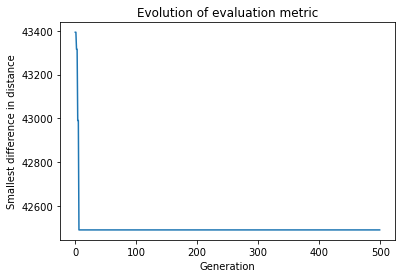

In [63]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest difference in distance')
plt.title('Evolution of evaluation metric')
plt.show()

In [64]:
print('The best configuration has a difference of distance of:',metric[-1],', ordered as below.')
print('The original order had a difference of',difference,'km. That means we reduced the total in',round(100*(1-metric[-1]/difference)),'%')

The best configuration has a difference of distance of: 42490.59215550201 , ordered as below.
The original order had a difference of 43393.29396573675 km. That means we reduced the total in 2 %


In [65]:
best_locations = gene_pool[0]
trek=[]
for jj in range(len(generic)):
    team_trek=[generic[jj]]+2*matches_solution.loc[generic[jj],:].tolist()+[generic[jj]]
    for ii in range(len(rounds)):
        if best_locations.loc[generic[jj],rounds[ii]]==0:
            team_trek[ii+1]=generic[jj]
        else:
            team_trek[ii+20]=generic[jj]

    trek.append(team_trek)
    
trek=pd.DataFrame(trek)

In [66]:
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[list_teams_solution.loc[trek.iloc[ii,jj],'Team'],
                                  list_teams_solution.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
list_teams_solution['Total Distance']=trek_list
list_teams_solution

,Team,Total Distance
Team,,
Team01,Atlético Goianiense,37736.142482
Team02,Atlético Mineiro,30100.618320
Team03,Athletico Paranaense,33733.382776
Team04,Bahia,42171.581196
Team05,Botafogo,28089.633545
Team06,Ceará,69076.818835
Team07,Corinthians,26723.256711
Team08,Coritiba,33176.144740
Team09,Flamengo,28190.258200


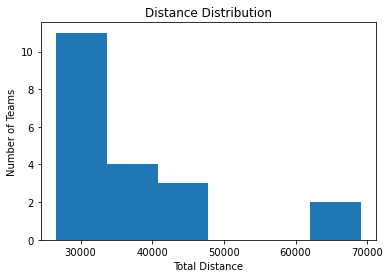

In [67]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

### 8.3 Third evaluation - Standard Deviation

In [68]:
gene_pool = []
gene_pool.append(locations)
jj = 0
for ii in range(5):
    ok = 1
    #we will create new configurations until we find a valid one 
    while ok > 0:
        location_gene = locations.copy()
        #randomly selecting a team and a round
        x1 = random.randint(0,19)
        x2 = random.randint(0,18)
        team1 = generic[x1]
        team2 = matches_solution.iloc[x1,x2]
        location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
        location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]
        
        ok = verifyCondition(location_gene)
         
    gene_pool.append(location_gene)


In [69]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 2 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(len(gene_pool)):
        scores.append(evaluation(list_teams_solution, gene_pool[ii], matches_solution)[method])
    
    #ranking results
    ranking = sorted(range(len(scores)), key=lambda k: scores[k])
    
    ranked_gene_pool = []
    for ii in range(len(gene_pool)):
        ranked_gene_pool.append(gene_pool[ranking[ii]])
    
    gene_pool = ranked_gene_pool
    
    #storing best result
    metric.append(np.min(scores))
    
    #creating new candidates    
    for ii in range(2,4):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[0].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene

    for ii in range(4,6):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok > 0:
            location_gene = gene_pool[1].copy()
            #randomly selecting a team and a round
            x1 = random.randint(0,19)
            x2 = random.randint(0,18)
            team1 = generic[x1]
            team2 = matches_solution.iloc[x1,x2]
            location_gene.loc[team1,rounds[x2]] = 1 - location_gene.loc[team1,rounds[x2]]
            location_gene.loc[team2,rounds[x2]] = 1 - location_gene.loc[team2,rounds[x2]]

            ok = verifyCondition(location_gene)

        gene_pool[ii] = location_gene
        
    #prepping for next generation
    generation += 1
    

Generation: 0
Generation: 50
Generation: 100
Generation: 150
Generation: 200
Generation: 250
Generation: 300
Generation: 350
Generation: 400
Generation: 450


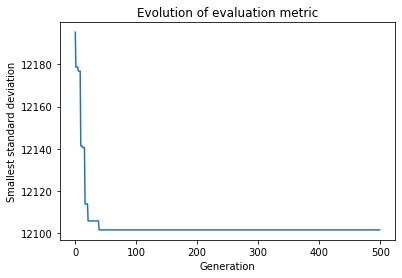

In [70]:
plt.plot(range(max_generation), metric)
plt.xlabel('Generation')
plt.ylabel('Smallest standard deviation')
plt.title('Evolution of evaluation metric')
plt.show()

In [71]:
print('The best configuration has a standard deviation of:',metric[-1],', ordered as below.')
print('The original order had a difference of',standard_deviation,'. That means we reduced the total in',round(100*(1-metric[-1]/standard_deviation)),'%')

The best configuration has a standard deviation of: 12101.671142290073 , ordered as below.
The original order had a difference of 12220.999097401962 . That means we reduced the total in 1 %


In [72]:
best_locations = gene_pool[0]
trek=[]
for jj in range(len(generic)):
    team_trek=[generic[jj]]+2*matches_solution.loc[generic[jj],:].tolist()+[generic[jj]]
    for ii in range(len(rounds)):
        if best_locations.loc[generic[jj],rounds[ii]]==0:
            team_trek[ii+1]=generic[jj]
        else:
            team_trek[ii+20]=generic[jj]

    trek.append(team_trek)
    
trek=pd.DataFrame(trek)

In [73]:
trek_list = []
for ii in range(trek.shape[0]):
    team_trek=0
    for jj in range(trek.shape[1]-1):
        team_trek += distances.loc[list_teams_solution.loc[trek.iloc[ii,jj],'Team'],
                                  list_teams_solution.loc[trek.iloc[ii,jj+1],'Team']]
    
    trek_list.append(team_trek)
list_teams_solution['Total Distance']=trek_list
list_teams_solution

,Team,Total Distance
Team,,
Team01,Atlético Goianiense,37736.142482
Team02,Atlético Mineiro,29473.996967
Team03,Athletico Paranaense,33733.382776
Team04,Bahia,42171.581196
Team05,Botafogo,28089.633545
Team06,Ceará,69076.818835
Team07,Corinthians,26723.256711
Team08,Coritiba,35121.776295
Team09,Flamengo,28190.258200


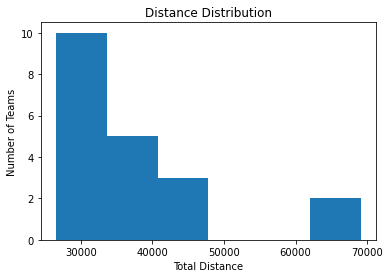

In [74]:
plt.hist(trek_list, bins = 6)
plt.xlabel('Total Distance')
plt.ylabel('Number of Teams')
plt.title('Distance Distribution')
plt.show()

Our results in this case is much worse than the ones optimizing the order of the teams. When we compare the improvements, we also see lower values.

## 9. Optimizing matches

We are going to modify the order of the rounds while keeping the order of the teams fixed. In this case, we will need to alter the location table too. In other words, we will modify the order of the columns in the matches table and also in the locations table. We still need to validate the condition that no team can play more than two games in a row at home or away.

In [75]:
list_teams_solution = list_teams.copy()

For this case, our gene is a vector with the reordering of the rounds.

In [76]:
print('That is, the vector (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) is :', rounds)

That is, the vector (0,1,2,3,4,5,6,7,8,9,10,11,12,13,141,15,16,17,18,19) is : ['Round 1', 'Round 2', 'Round 3', 'Round 4', 'Round 5', 'Round 6', 'Round 7', 'Round 8', 'Round 9', 'Round 10', 'Round 11', 'Round 12', 'Round 13', 'Round 14', 'Round 15', 'Round 16', 'Round 17', 'Round 18', 'Round 19']


At the end of our algorithm, we will present a graph with the evolution of the best evaluation function for each generation. We hope to find an optimized value.<br>
We have four parameters to define:
1. the number of genes (configurations) we will evaluate in each generation: **6**;
2. the number of genes we will use to create the new generation: **2**;
3. the number of generations: **500**;
4. the original configurations.

The creation of an original set of valid configurations is more complex in this case. From the original table, we are going to generate 5 new tables, with only one mutation each.

In [77]:
gene_pool = []
gene_pool.append(rounds)
for ii in range(5):
    ok = 1
    #we will create new configurations until we find a valid one 
    while ok>0:
        rounds_gene = rounds.copy()
        x1 = random.randint(0,18)
        x2 = x1
        while x2 == x1:
            x2 = random.randint(0,18)
        pos1 = rounds_gene[x1]
        pos2 = rounds_gene[x2]
        rounds_gene[x1] = pos2
        rounds_gene[x2] = pos1
                
        ok = verifyCondition(location_solution[rounds_gene])
    gene_pool.append(rounds_gene)

### 9.1 First evaluation - Total sum

In [ ]:
generation=0
max_generation=500
metric=[]
# Choose evaluation function: (0) Total (1) Difference (2) Standard Deviation
method = 0 
while (generation < max_generation):
    if (generation%50 == 0):
        print('Generation:', generation)
    scores = []
    #for each gene
    for ii in range(len(gene_pool)):
        location_solution = locations[gene_pool[ii]]
        matches_solution = matches[gene_pool[ii]]
        
        #evaluation function
        scores.append(evaluation(list_teams_solution, location_solution, matches_solution)[method])
    
    #ranking results
    ranking = sorted(range(len(scores)), key=lambda k: scores[k])
    
    ranked_gene_pool = []
    for ii in range(len(gene_pool)):
        ranked_gene_pool.append(gene_pool[ranking[ii]])
    
    gene_pool = ranked_gene_pool    
    
    #storing best result
    metric.append(np.min(scores))
    
    #creating new candidates
    for ii in range(2,4):
        ok = 1
        jj=0
        #we will create new configurations until we find a valid one 
        while ok>0:
            new_gene = gene_pool[0]
            x1 = random.randint(0,18)
            x2 = x1
            while x2 == x1:
                x2 = random.randint(0,18)
            pos1 = new_gene[x1]
            pos2 = new_gene[x2]
            new_gene[x1] = pos2
            new_gene[x2] = pos1
            location_test = locations[new_gene]

            ok = verifyCondition(location_test)
            jj+=1
            if jj%100==0:
                print(ii,jj)
        gene_pool[ii] = new_gene
        
    for ii in range(4,6):
        ok = 1
        #we will create new configurations until we find a valid one 
        while ok>0:
            new_gene = gene_pool[1]
            x1 = random.randint(0,18)
            x2 = x1
            while x2 == x1:
                x2 = random.randint(0,18)
            pos1 = new_gene[x1]
            pos2 = new_gene[x2]
            new_gene[x1] = pos2
            new_gene[x2] = pos1
            
            location_test = locations[new_gene]


            ok = verifyCondition(location_test)
        gene_pool[ii] = new_gene
    
    #prepping for next generation
    generation += 1
    

**We had to stop this run, because it wasn't able to find new valid configurations.** This is independent of the evaluation function, so we won't be proceeding with this kind of optimization.

## 10. Conclusion

The Traveling Tournament Problem is really complex, and creating a competition with 20 teams is very hard. We split the problem in three tables and tried approaching the task one by one. Even so, we were able to move forward with two of them.

We found that changing the order of the teams has a bigger impact than modifying the location of the games. In the former, we had a maximum distance traveled close to 54k kilometers, while in the latter it was close to 70k. 

This solution can be applied to any new Brazilian Championship. For the 2021 edition, we should update the list of teams and their cities, and then run the optimization of the order of the teams using the standard deviation as an evaluation metric.

# **Final Conclusion: we can generate an optimized tournament using genetic algorithms by modifying the order of the teams using standard deviation as an evaluation metric.**